#Dataset and library

In [1]:
!pip install -q autodistill autodistill-grounded-sam autodistill-yolov8 supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 kB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 113.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.4 MB/s eta 0:00:00


In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt" -O milk.zip && rm -rf /tmp/cookies.txt
!unzip milk.zip -d ./videos/

--2023-10-14 11:05:53--  https://docs.google.com/uc?export=download&confirm=t&id=1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt
Resolving docs.google.com (docs.google.com)... 172.217.194.102, 172.217.194.138, 172.217.194.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ghlvl3l5fhbveflc61c4i6or8jveaa4c/1697281500000/04309230031174164349/*/1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt?e=download&uuid=16b3a94d-e480-473a-a0ac-625d47bc54ba [following]
--2023-10-14 11:05:53--  https://doc-08-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ghlvl3l5fhbveflc61c4i6or8jveaa4c/1697281500000/04309230031174164349/*/1wnW7v6UTJZTAcOQj0416ZbQF8b7yO6Pt?e=download&uuid=16b3a94d-e480-473a-a0ac-625d47bc54ba
Resolving doc-08-ag-docs.googleusercontent.com (doc-08-ag-docs.googleusercontent.com)... 64.233.170.1

In [3]:
import supervision as sv
from tqdm.notebook import tqdm

VIDEO_DIR_PATH = f"./videos"
IMAGE_DIR_PATH = f"./images"
FRAME_STRIDE = 4

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
TEST_IMAGE_DIR_PATH = './test_images'

for video_path in tqdm(TEST_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=TEST_IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/2 [00:00<?, ?it/s]

# Teacher model predictions

In [5]:
from autodistill.detection import CaptionOntology
from autodistill_grounded_sam import GroundedSAM

ontology = CaptionOntology({
    "milk bottle": "bottle",
    "blue cap": "cap"
})

base_model = GroundedSAM(ontology=ontology)

trying to load grounding dino directly
downloading dino model weights


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


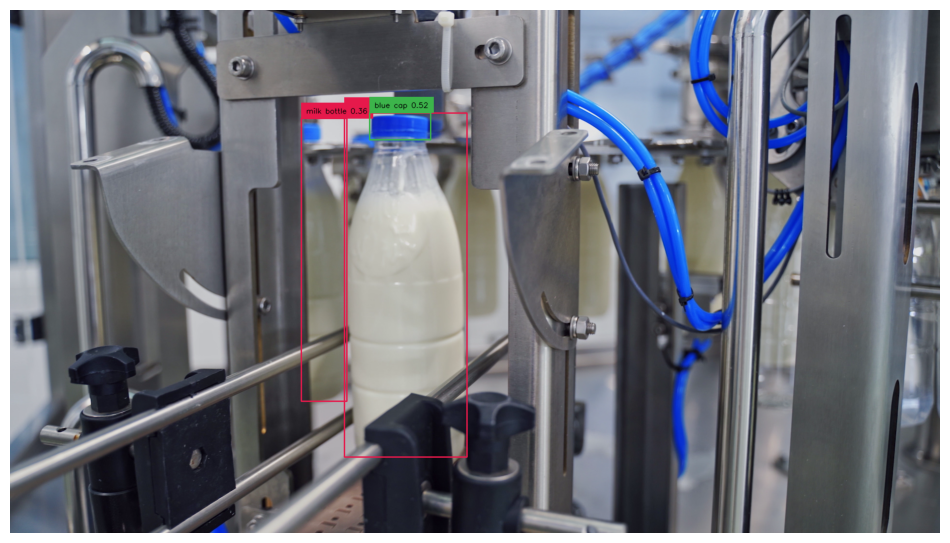

In [8]:
import cv2
import supervision as sv

test_image = '/content/milk-video-1-00000.png'

image = cv2.imread(test_image)

classes = ["milk bottle", "blue cap"]

detections = base_model.predict('/content/milk-video-1-00000.png')

box_annotator = sv.BoxAnnotator()

labels = [f"{classes[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _ in detections]

annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

sv.plot_image(annotated_frame)

In [9]:
DATASET_DIR_PATH = f"./dataset"

dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

Labeling ./images/milk-video-3-00037.png: 100%|██████████| 409/409 [09:12<00:00,  1.35s/it]


Labeled dataset created - ready for distillation.


#Train YOLO


In [11]:
from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train('./dataset/data.yaml', epochs=50)

New https://pypi.org/project/ultralytics/8.0.198 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, 

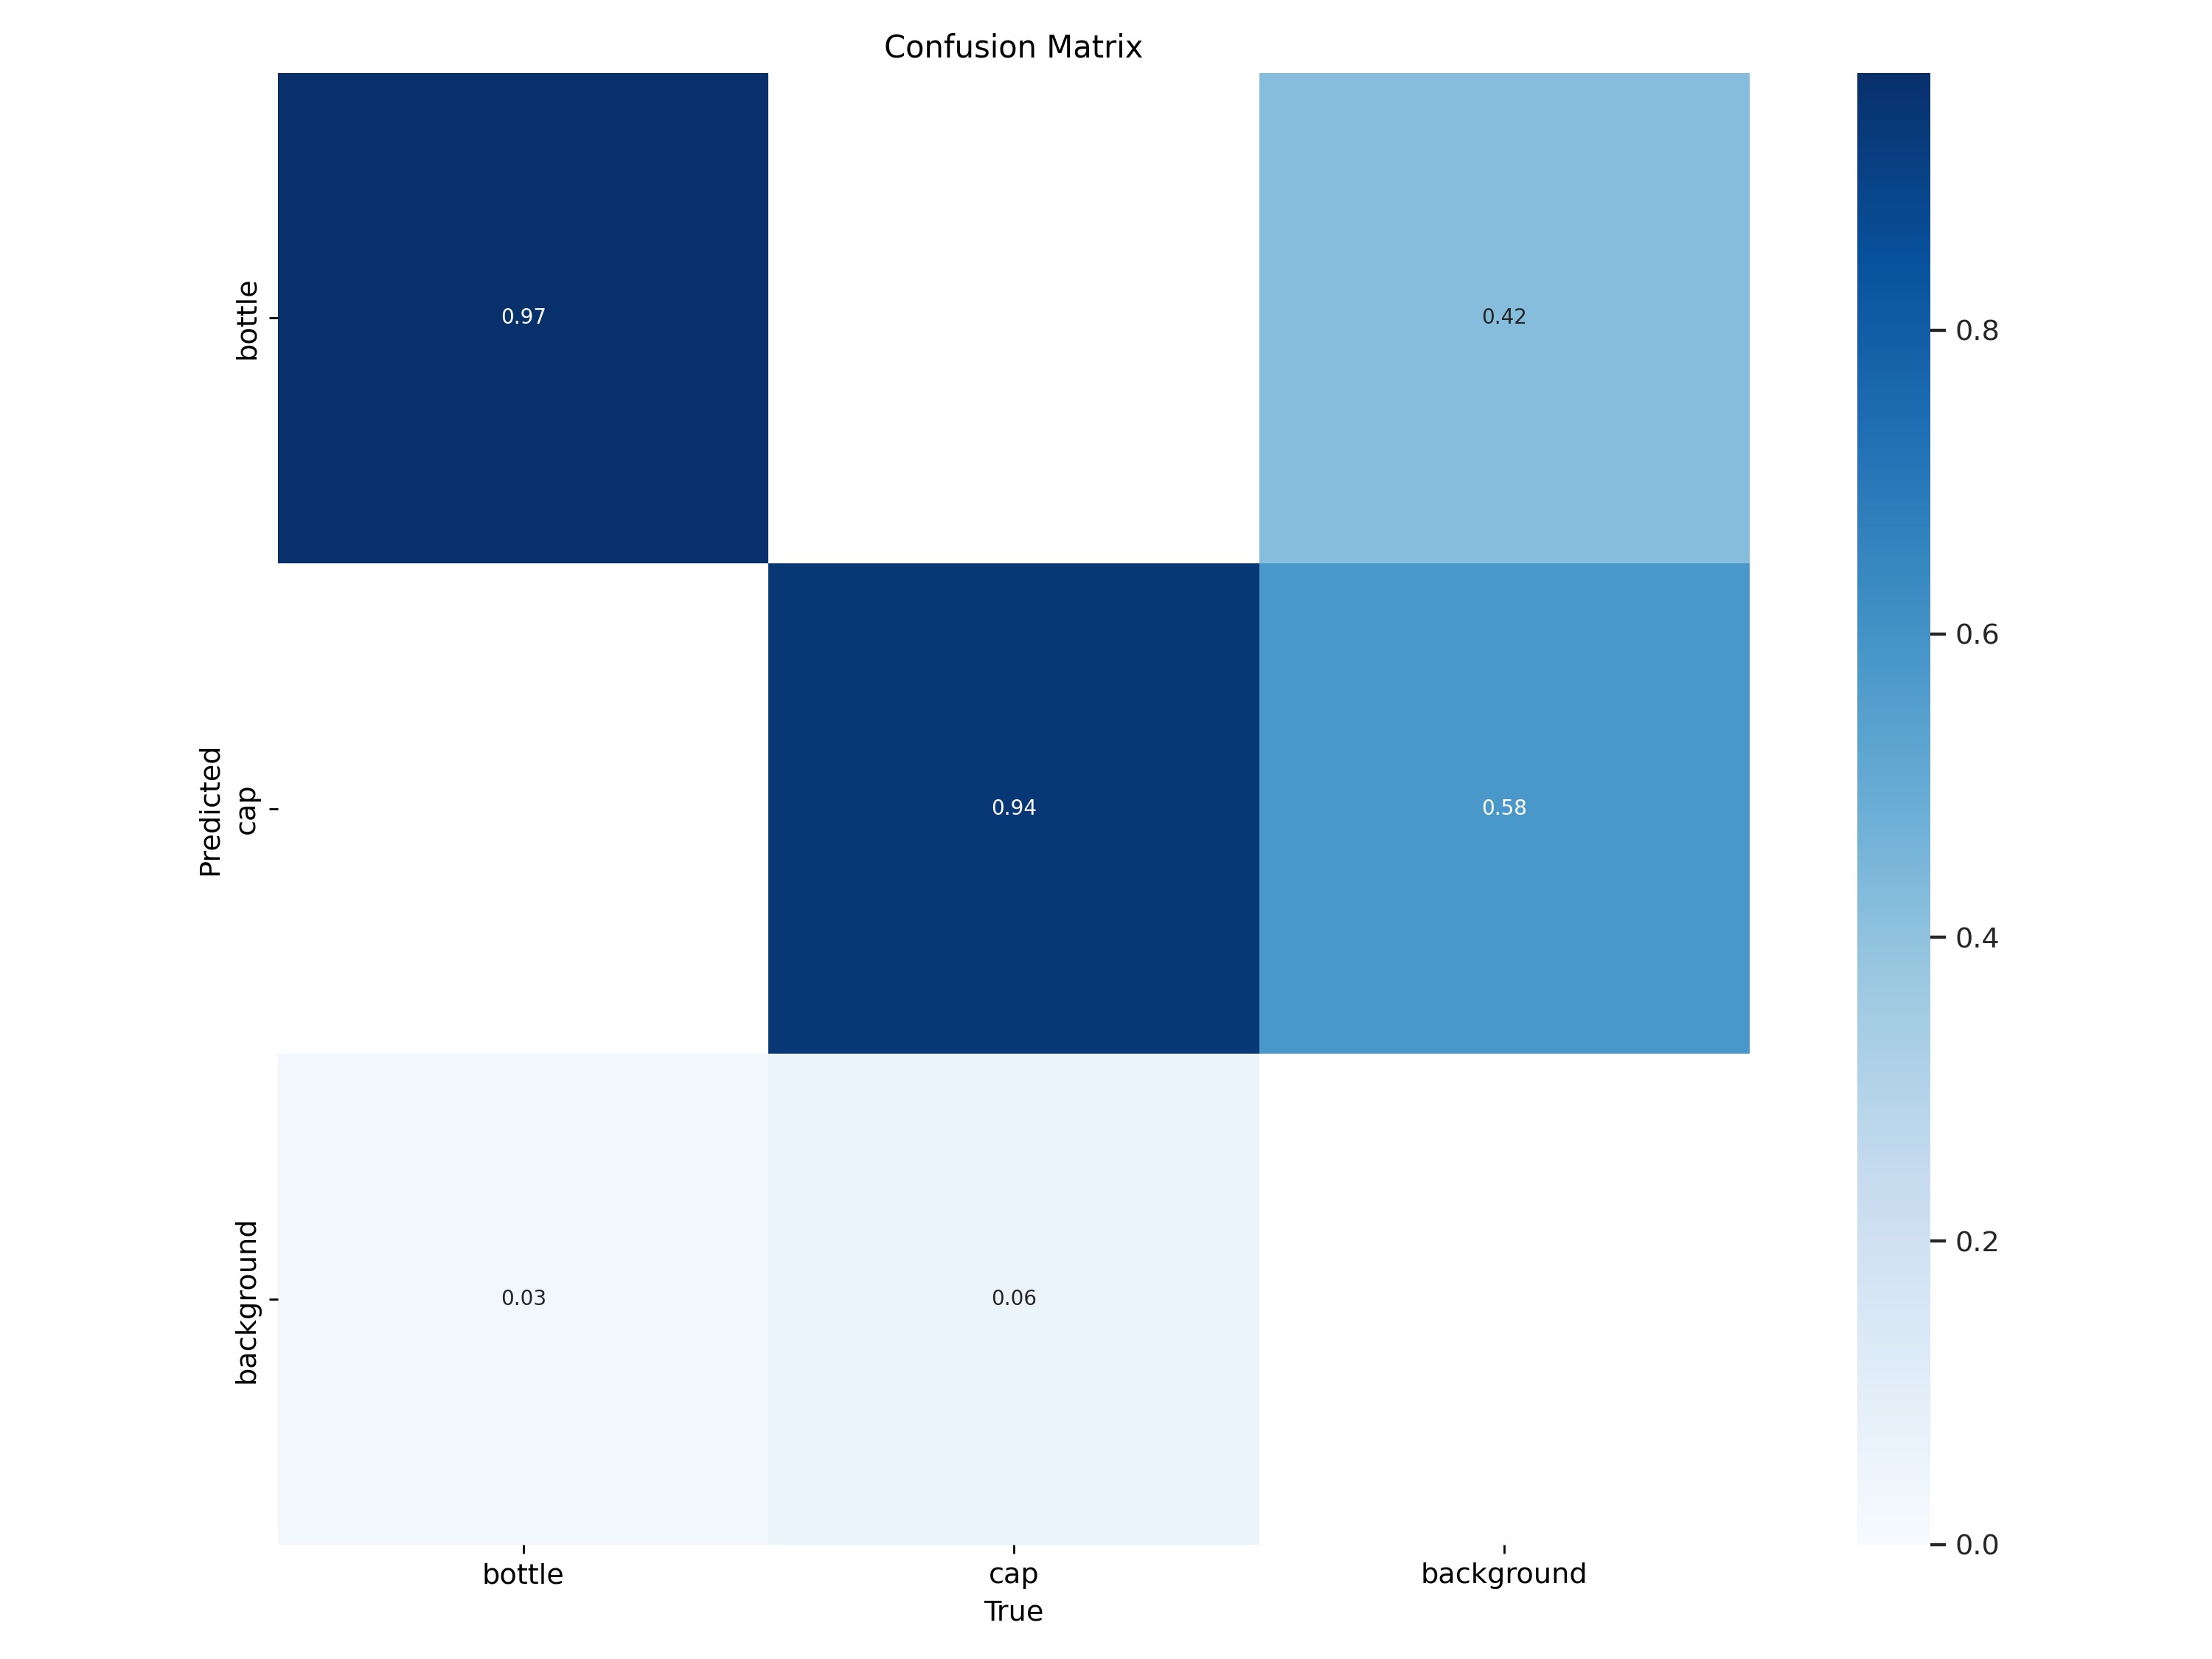

In [13]:
from IPython.display import Image

Image(filename=f'./runs/detect/train2/confusion_matrix.png', width=600)

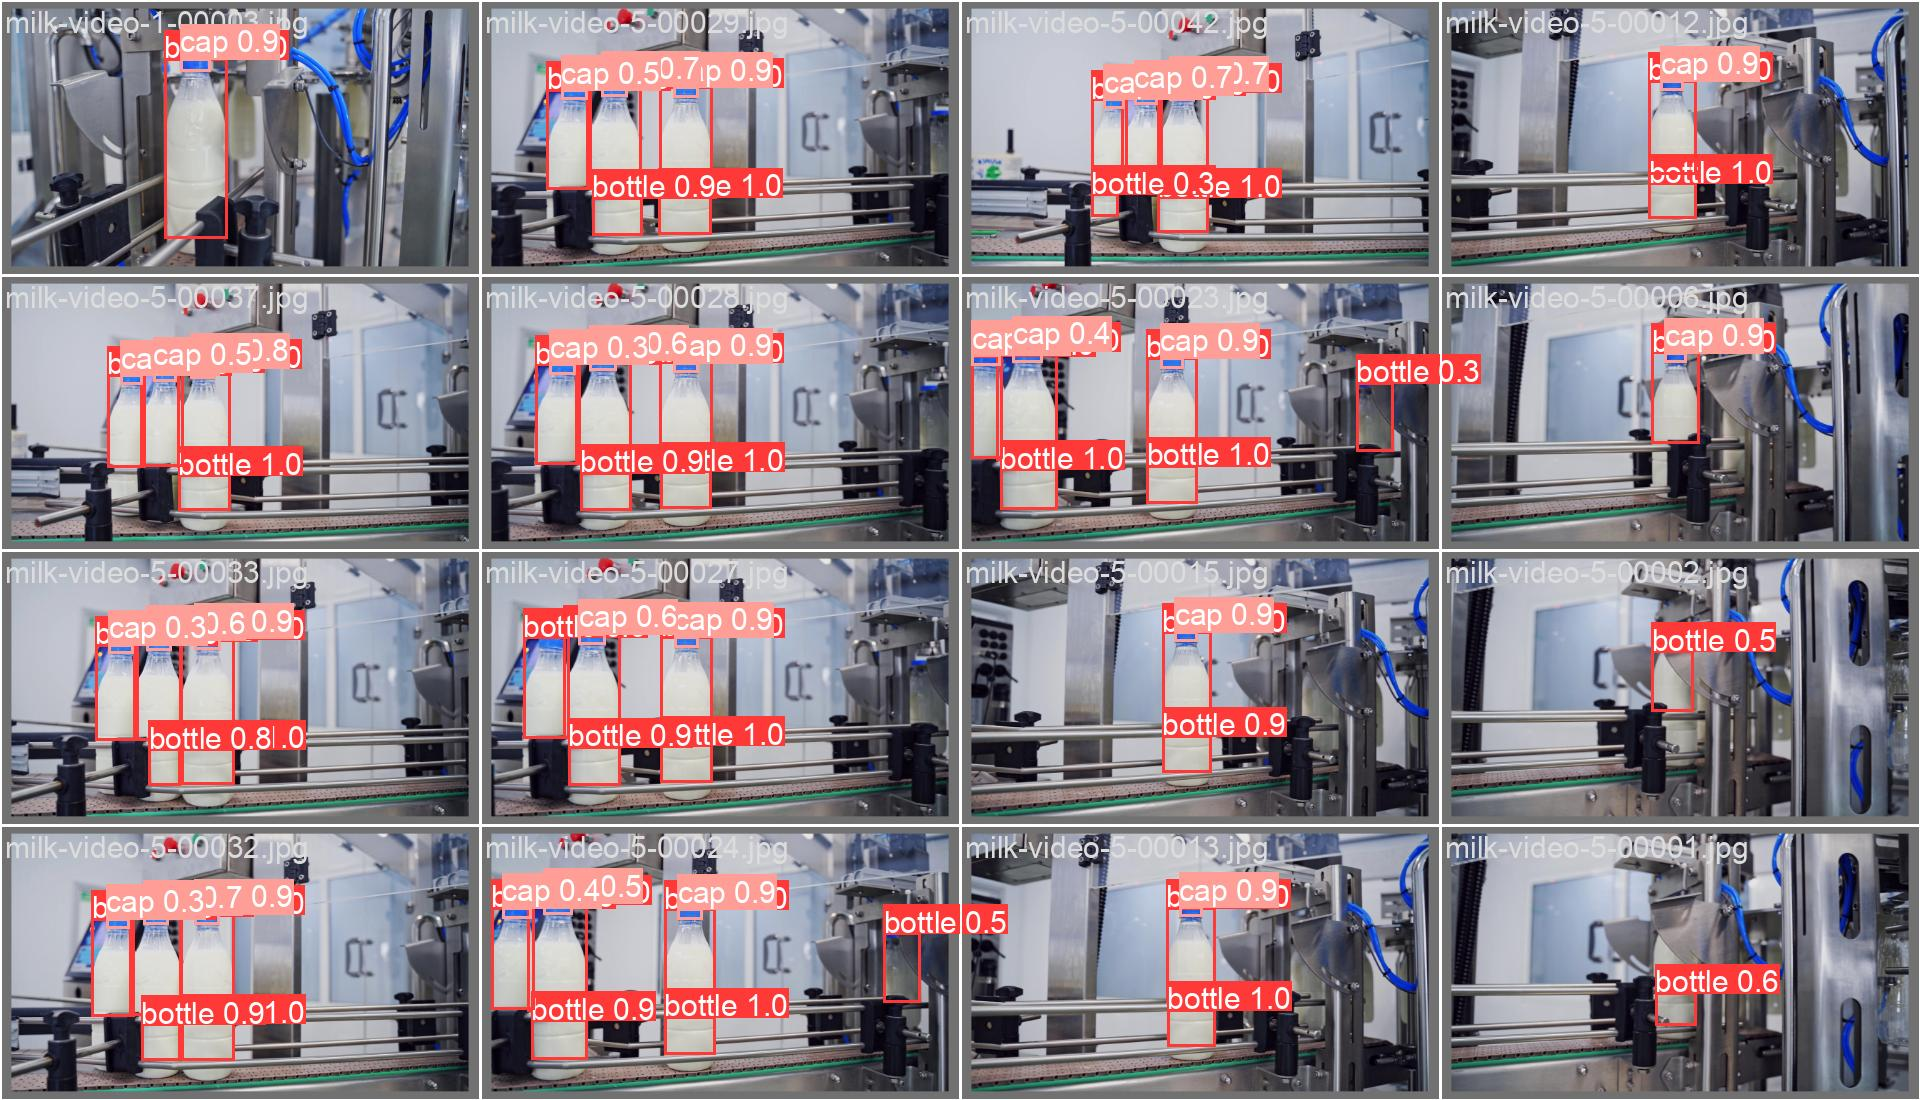

In [14]:
Image(filename=f'./runs/detect/train2/val_batch0_pred.jpg', width=600)

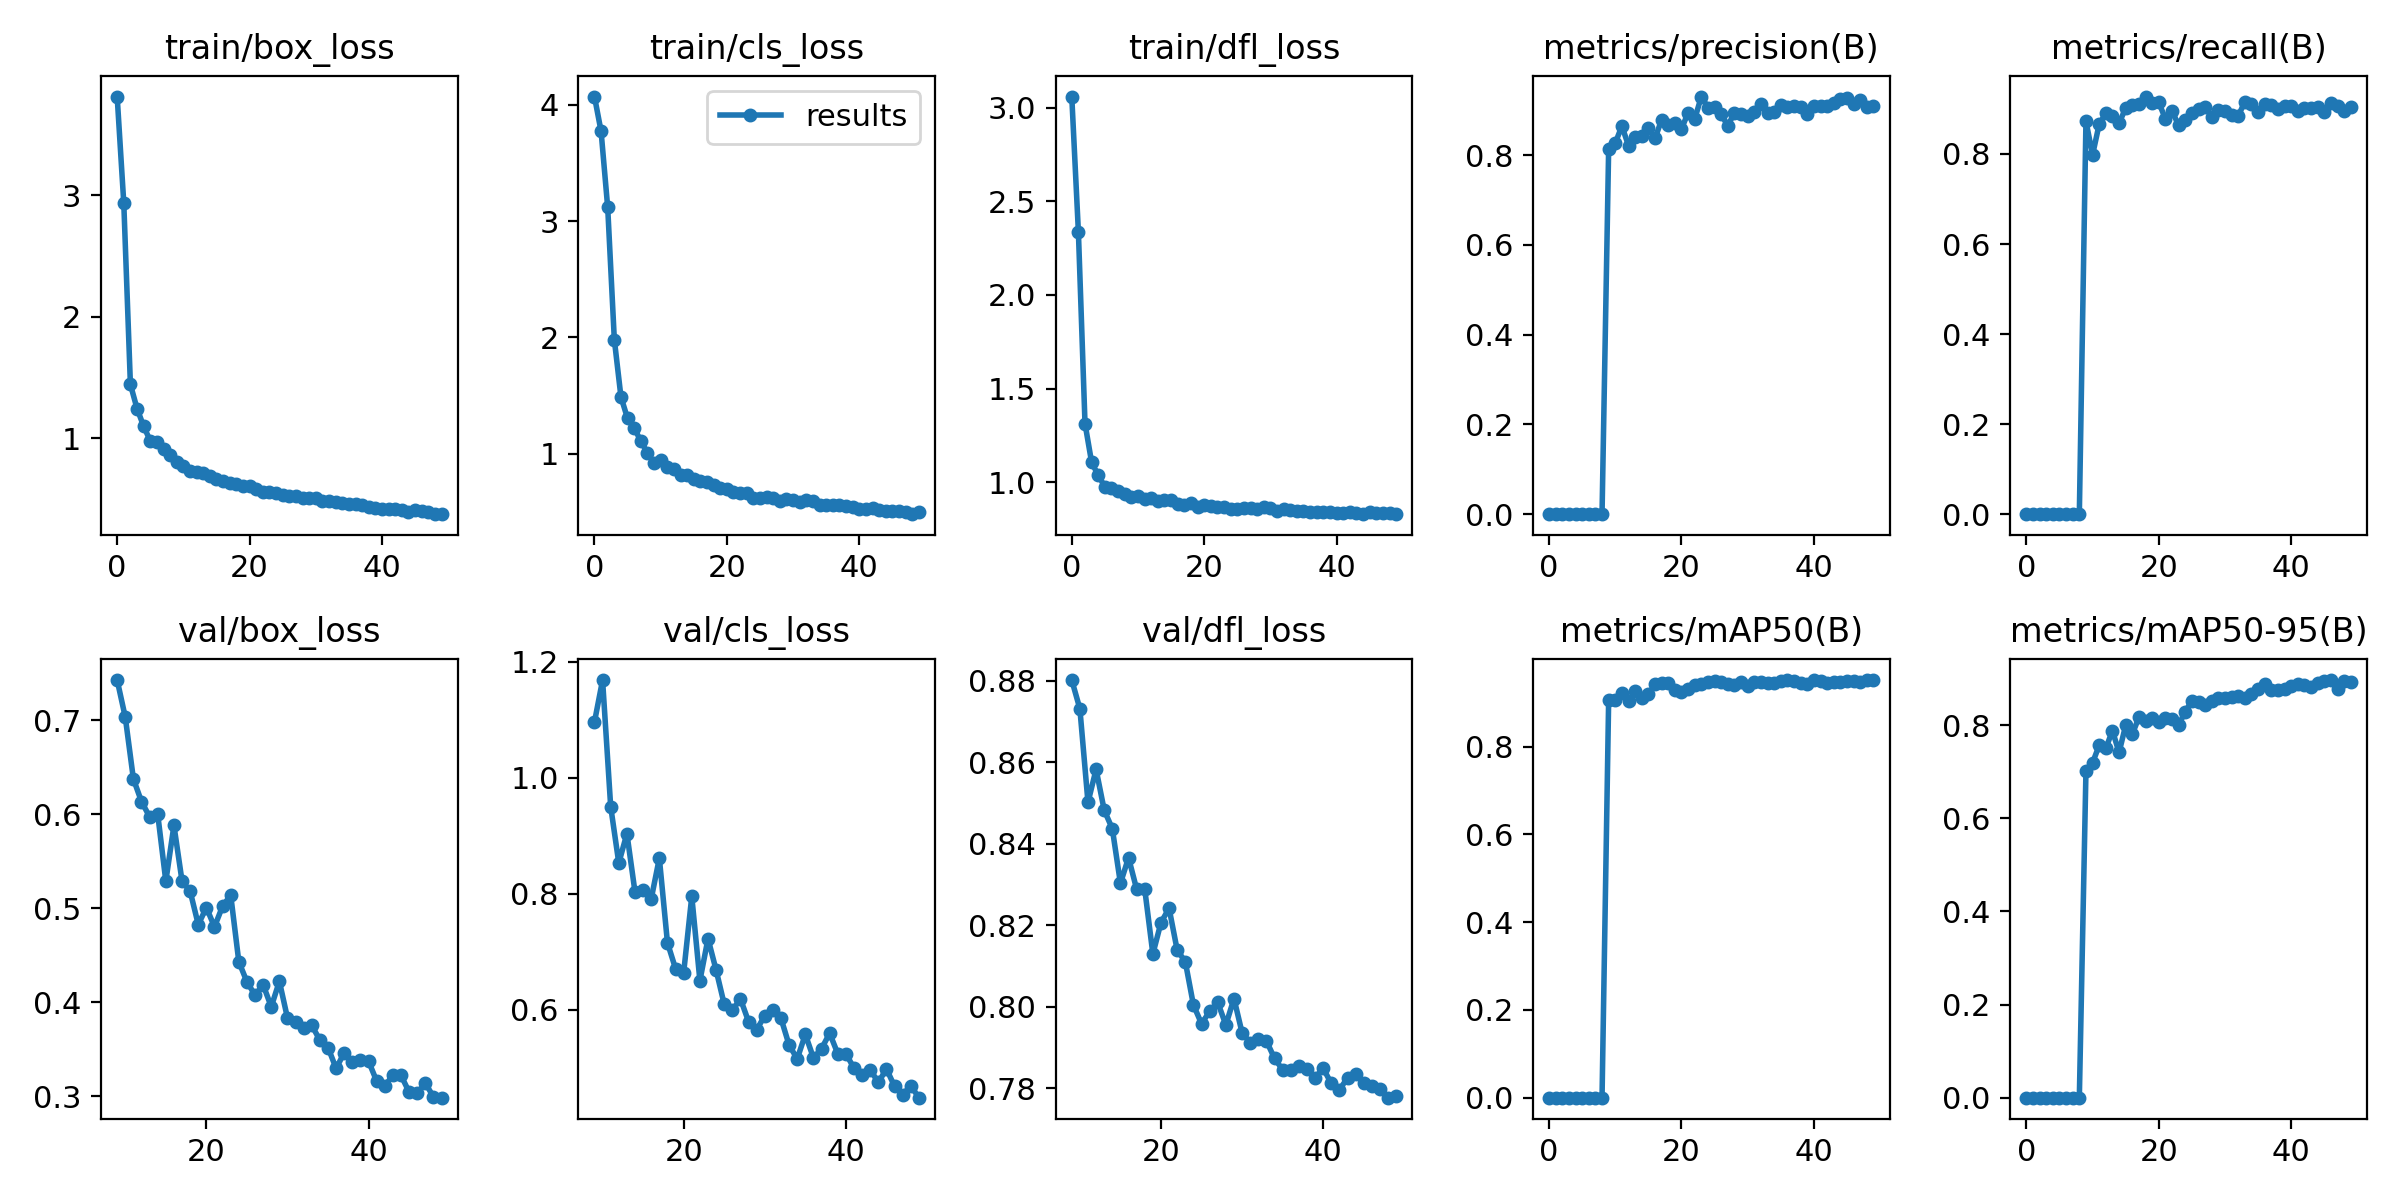

In [19]:
from IPython.display import Image

Image(filename=f'./runs/detect/train2/results.png', width=600)

In [20]:
def check_model_size(model):
    buffer_size, param_size = 0, 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2

    return size_all_mb

In [24]:
check_model_size(target_model.yolo.model)

11.527069091796875

In [28]:
check_model_size(base_model.grounding_dino_model.model) + check_model_size(base_model.sam_predictor.model)

3105.1262817382812